## PPO (Proximal Policy Optimization)
### PPO 惩罚（PPO-Penalty）
- PPO 通过惩罚策略梯度来惩罚策略的方差，而不是惩罚策略梯度本身。
- PPO-惩罚（PPO-Penalty）用拉格朗日乘数法直接将 KL 散度的限制放进了目标函数中，这就变成了一个无约束的优化问题，在迭代的过程中不断更新 KL 散度前的系数。
- $\arg\max_\theta \mathbb{E}t \left[ \frac{\pi\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)} A_t - \beta \cdot D_{KL}\left[\pi_{\theta_{old}}(\cdot|s_t) | \pi_\theta(\cdot|s_t)\right] \right]$
- 公式说明：
    - $\theta$：当前策略参数
    - $\theta_{old}$：旧策略参数（采样时的策略）
    - $\frac{\pi_\theta}{\pi_{\theta_{old}}}$：重要性采样比
    - $A_t$：优势函数（如GAE估计）
    - $\beta$：自适应KL惩罚系数
    - $D_{KL}$：KL散度，约束策略更新的幅度
- 特点：
    - 通过KL散度直接惩罚策略更新幅度
    - $\beta$ 通常动态调整（如根据KL散度均值调整）
    - 是PPO算法的两种主要变体之一（另一种是PPO-Clip）


### PPO-截断（PPO-Clip）
- $$ L^{CLIP}(\theta) = \mathbb{E}t \left[ \min\left( \frac{\pi\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)} A_t,\ \text{clip}\left( \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}, 1-\epsilon, 1+\epsilon \right) A_t \right) \right] $$
-
- PPO 的另一种形式 PPO-截断（PPO-Clip）更加直接，它在目标函数中进行限制，以保证新的参数和旧的参数的差距不会太大
- $\arg\max_\theta \mathbb{E}t \left[ \min\left( \frac{\pi\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)} A_t,\ \text{clip}\left( \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}, 1-\epsilon, 1+\epsilon \right) A_t \right) \right]$
- 说明：
    - 核心机制：通过截断（clip）限制策略更新的幅度，避免过大的策略变化
- 参数：
    - $\theta$：当前策略参数
    - $\theta_{old}$：旧策略参数（采样时的策略）
    - $\epsilon$：截断阈值（超参数，通常设为0.1~0.3）
- 关键操作：
    - $\frac{\pi_\theta}{\pi_{\theta_{old}}}$：重要性采样比
    - $A_t$：优势函数（如GAE估计）
    - $\text{clip}(x,1-\epsilon,1+\epsilon)$：将$x$限制在$[1-\epsilon,1+\epsilon]$区间内
- 特点：
    - 直接限制策略比的变化范围（而非像PPO-Penalty用KL散度约束）
    - 实现更简单且效果稳定（OpenAI默认采用此版本）
    - 双$\min$结构保证策略更新时同时考虑性能提升和更新幅度

In [3]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm


class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps,
                                1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [9]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("mps") if torch.backends.mps.is_available() else \
    torch.device("cuda") if torch.cuda.is_available() else \
        torch.device("cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes/10)):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            state,info = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

Iteration 9: 100%|██████████| 50/50 [00:39<00:00,  1.27it/s, episode=500, return=491.100]


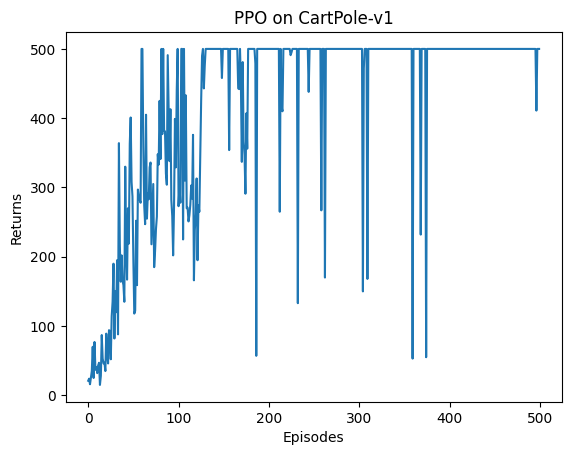

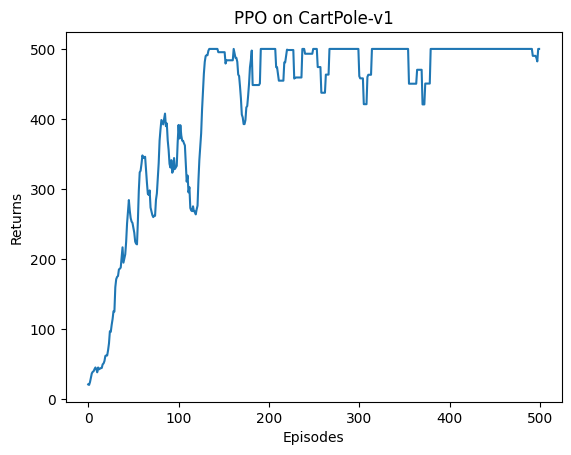

In [5]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

### 倒立摆


In [6]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std


class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        return [action.item()]

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 和TRPO一样,对奖励进行修改,方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        # 动作是正态分布
        old_log_probs = action_dists.log_prob(actions)

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [7]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes/10)):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            state,info = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

Iteration 9: 100%|██████████| 200/200 [01:42<00:00,  1.95it/s, episode=2000, return=-460.810]


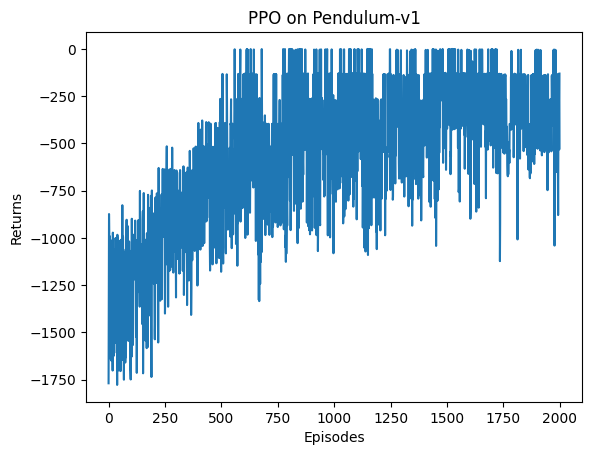

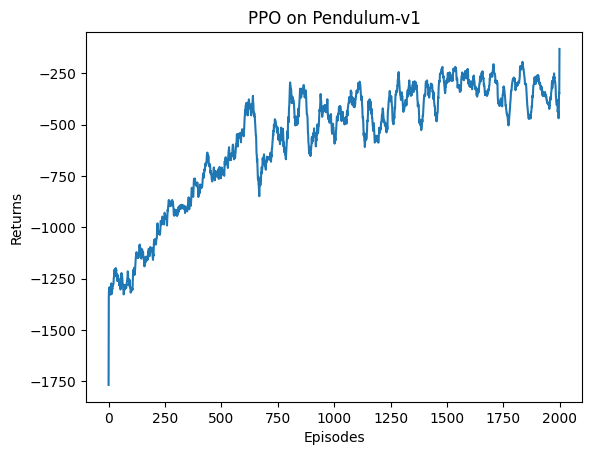

In [8]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()